In [90]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Flatten, RNN, GRU
#from tensorflow.compat.v1.keras.layers import CuDNNGRU
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
class f_model:
    def __init__(self, theta_range, x_range, N_x, dx):
        #Theta_range is the span of parameters a, b and c. 
        #x_range is the (x_start_x_stop) values that are allowed for x to start 
        #N_x is how many points in x_range that will be trained on.
        self.theta_range = theta_range 
        self.x_range = x_range 
        self.N_x = N_x 
        self.dx = dx
        
    def give_rand_theta(self): 
        theta_rand = [np.random.uniform(th[0], th[1]) for th in self.theta_range]
        self.theta = theta_rand
        return theta_rand 
    
    def calc_output(self): 
        y = self.give_rand_theta() 
        x_start = np.random.uniform(self.x_range[0], self.x_range[1]) 
        x = np.array([x_start + i*dx for i in range(self.N_x)])
        return np.array([x, self.f(x)]), y
    
    def f(self, x): 
        return self.theta[0]*x**2 + self.theta[1]*x + self.theta[2]
    

In [72]:
theta_range = [(-5, 5), (-5, 5), (-10, 10)]
x_range = (-2, 2)
dx = 0.05 
N_x = 50 

X_NN = []
y_NN = [] 

N_sim = 100000
mod = f_model(theta_range, x_range, N_x, dx)
for i in range(N_sim): 
    X, y = mod.calc_output() #Returns X as shape (N_vars, N_steps)
    X_NN.append(X.T) 
    y_NN.append(y)
    
X_NN = np.array(X_NN) 
y_NN = np.array(y_NN)

In [73]:
class Scaler_class: 
    def __init__(self): 
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
    def fit(self, X_NN, y_NN): #Data shape = (N_sim, N_steps, N_var)
        self.y_scaler = self.y_scaler.fit(y_NN)
        
        X_NN_temp = X_NN.reshape(-1, X_NN.shape[-1])
        self.x_scaler = self.X_scaler.fit(X_NN_temp)
        X_NN_temp = self.X_scaler.transform(X_NN_temp).reshape(X_NN.shape)
                    
            
        return X_NN_temp, self.y_scaler.transform(y_NN)
    
    def transform(self, X_NN, y_NN): 
        X_NN_temp = X_NN.reshape(-1, X_NN.shape[-1])
        X_NN_temp = self.X_scaler.transform(X_NN_temp).reshape(X_NN.shape)
            
        return X_NN_temp, self.y_scaler.transform(y_NN)
            

In [74]:
Scaler = Scaler_class()
X_sc, y_sc = Scaler.fit(X_NN, y_NN)
X_train, X_test, y_train, y_test  = train_test_split(X_sc, y_sc, test_size=0.2)

In [68]:
N_h1 = 200
N_h2 = 200

N_vars = 2
N_seq = N_x
N_out = 3

#Functional API model 
inputs = keras.Input(shape=(N_seq, N_vars), name="Variables")
NN = Dense(N_h1, activation='relu', name="NN1")(inputs)
NN = Flatten(name="Flatten_Layer1")(NN)
NN = Dense(N_h2, activation='relu', name="NN2")(NN)

output = Dense(N_out, name="Out1")(NN)

model = keras.Model(inputs=inputs, outputs=output, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Variables (InputLayer)       [(None, 100, 2)]          0         
_________________________________________________________________
NN1 (Dense)                  (None, 100, 200)          600       
_________________________________________________________________
Flatten_Layer1 (Flatten)     (None, 20000)             0         
_________________________________________________________________
NN2 (Dense)                  (None, 200)               4000200   
_________________________________________________________________
Out1 (Dense)                 (None, 3)                 603       
Total params: 4,001,403
Trainable params: 4,001,403
Non-trainable params: 0
_________________________________________________________________


In [9]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0616 - accuracy: 0.5027 - val_loss: 0.0600 - val_accuracy: 0.5149
Epoch 2/20
 892/2500 [=========>....................] - ETA: 5s - loss: 0.0557 - accuracy: 0.5367

KeyboardInterrupt: 

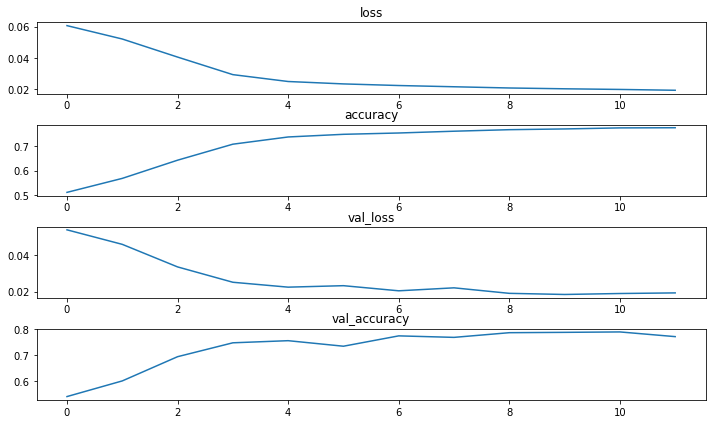

In [152]:
hist = history.history 
fig, axes = plt.subplots(len(hist), 1)
for el, ax in zip(hist, axes): 
    ax.plot(hist[el])
    ax.set_title(el)
    
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout(h_pad=-0.2)
plt.show()  

In [158]:
[x, f], theta = mod.calc_output()

In [159]:
X = np.array([x, f]).T.reshape(1, 10, 2)

In [161]:
X_pred, y_res = Scaler.transform(X, [theta])

print(f"Predicted is {model.predict(X_pred)} while real is {y_res}")

Predicted is [[0.26025844 0.2892427  0.60391754]] while real is [[0.2567822  0.26481425 0.85379906]]


In [75]:
N_h1 = 100
N_h2 = 200

N_vars = 2
N_seq = N_x
N_out = 3

#Functional API model 
inputs = keras.Input(shape=(N_seq, N_vars), name="Variables")
#input1 = Flatten(name="Flattening")(inputs)
x_n = tf.split(inputs, num_or_size_splits=N_seq//5, axis=1, name="Split1") 
NN1 = [Dense(N_h1, activation='relu', name=f"NN1_x{i+1}")(x1) for i, x1 in enumerate(x_n)]
#NN2 = Dense(N_h1, activation='relu', name=f"NN1_x{i+1}")(inputs)
#NN1.append(NN2)
NN = Concatenate(axis=1, name="Out2")(NN1)
NN = Dense(N_h2, activation='relu', name="NN2")(NN)
NN = Flatten()(NN)
output = Dense(N_out, name="Out1")(NN)

model = keras.Model(inputs=inputs, outputs=output, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Variables (InputLayer)          [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Split1_12 (TensorFl [(None, 5, 2), (None 0           Variables[0][0]                  
__________________________________________________________________________________________________
NN1_x1 (Dense)                  (None, 5, 100)       300         tf_op_layer_Split1_12[0][0]      
__________________________________________________________________________________________________
NN1_x2 (Dense)                  (None, 5, 100)       300         tf_op_layer_Split1_12[0][1]      
_______________________________________________________________________________________

In [62]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [76]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0290 - accuracy: 0.6934 - val_loss: 0.0184 - val_accuracy: 0.7752
Epoch 2/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0132 - accuracy: 0.7983 - val_loss: 0.0087 - val_accuracy: 0.8442
Epoch 3/20
2500/2500 [==============================] - 11s 5ms/step - loss: 0.0096 - accuracy: 0.8342 - val_loss: 0.0073 - val_accuracy: 0.8480
Epoch 4/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0076 - accuracy: 0.8519 - val_loss: 0.0074 - val_accuracy: 0.8438
Epoch 5/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0068 - accuracy: 0.8635 - val_loss: 0.0076 - val_accuracy: 0.8551
Epoch 6/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0057 - accuracy: 0.8745 - val_loss: 0.0045 - val_accuracy: 0.8974
Epoch 7/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0052 - accuracy: 0.8816 - val_loss: 0.0032 - val_ac

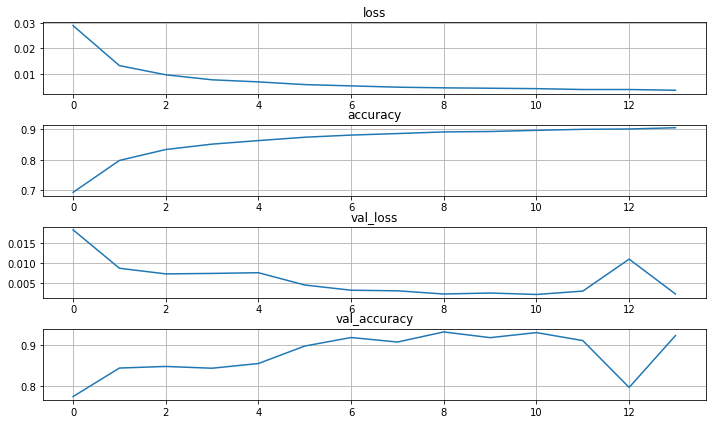

In [78]:
hist = history.history 
fig, axes = plt.subplots(len(hist), 1)
for el, ax in zip(hist, axes): 
    ax.plot(hist[el])
    ax.set_title(el)
    ax.grid()
    
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout(h_pad=-0.2)
plt.show()  

In [91]:
N_h1 = 100
N_h2 = 200

N_vars = 2
N_seq = N_x
N_out = 3

#Functional API model 
inputs = keras.Input(shape=(N_seq, N_vars), name="Variables")
#rnn = tf.contrib.cudnn_rnn.CudnnGRU(100, 100)

#RNN1 = rnn(inputs)
RNN1 = GRU(N_h1)(inputs)

NN = Dense(N_h2, activation='relu', name="NN2")(RNN1)
NN = Flatten()(NN)
output = Dense(N_out, name="Out1")(NN)

model = keras.Model(inputs=inputs, outputs=output, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Variables (InputLayer)       [(None, 50, 2)]           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               31200     
_________________________________________________________________
NN2 (Dense)                  (None, 200)               20200     
_________________________________________________________________
flatten_14 (Flatten)         (None, 200)               0         
_________________________________________________________________
Out1 (Dense)                 (None, 3)                 603       
Total params: 52,003
Trainable params: 52,003
Non-trainable params: 0
_________________________________________________________________


In [92]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
2500/2500 [==============================] - 54s 22ms/step - loss: 0.0233 - accuracy: 0.7420 - val_loss: 0.0027 - val_accuracy: 0.9058
Epoch 2/20
2500/2500 [==============================] - 53s 21ms/step - loss: 0.0024 - accuracy: 0.9225 - val_loss: 0.0018 - val_accuracy: 0.9128
Epoch 3/20
2500/2500 [==============================] - 53s 21ms/step - loss: 0.0020 - accuracy: 0.9313 - val_loss: 8.9204e-04 - val_accuracy: 0.9477
Epoch 4/20
2500/2500 [==============================] - 52s 21ms/step - loss: 0.0014 - accuracy: 0.9419 - val_loss: 0.0016 - val_accuracy: 0.9408
Epoch 5/20
2500/2500 [==============================] - 52s 21ms/step - loss: 0.0011 - accuracy: 0.9515 - val_loss: 4.6577e-04 - val_accuracy: 0.9682
Epoch 6/20
2500/2500 [==============================] - 52s 21ms/step - loss: 9.4446e-04 - accuracy: 0.9538 - val_loss: 0.0016 - val_accuracy: 0.9378
Epoch 7/20
2500/2500 [==============================] - 52s 21ms/step - loss: 9.7369e-04 - accuracy: 0.9538 - va

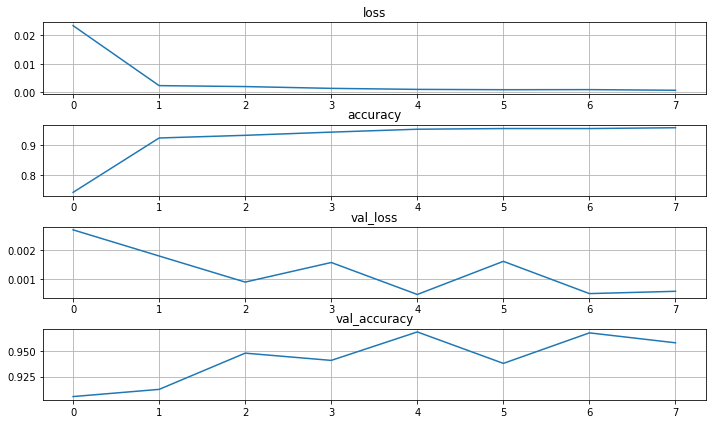

In [93]:
hist = history.history 
fig, axes = plt.subplots(len(hist), 1)
for el, ax in zip(hist, axes): 
    ax.plot(hist[el])
    ax.set_title(el)
    ax.grid()
    
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout(h_pad=-0.2)
plt.show()  